# On this notebook the best models and input parameters will be searched for. The problem at hand is predicting the price of any stock symbol 1 day ahead, assuming one model for all the symbols. The best training period length, base period length, and base period step will be determined, using the MRE metrics (and/or the R^2 metrics). The step for the rolling validation will be determined taking into consideration a compromise between having enough points (I consider about 1000 different target days may be good enough), and the time needed to compute the validation.

In [1]:
# Basic imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import scipy.optimize as spo
import sys
from time import time
from sklearn.metrics import r2_score, median_absolute_error

%matplotlib inline

%pylab inline
pylab.rcParams['figure.figsize'] = (20.0, 10.0)

%load_ext autoreload
%autoreload 2

sys.path.append('../../')
import predictor.feature_extraction as fe
import utils.preprocessing as pp
import utils.misc as misc

Populating the interactive namespace from numpy and matplotlib


In [2]:
AHEAD_DAYS = 1

## Let's get the data.

In [3]:
datasets_params_list_df = pd.read_pickle('../../data/datasets_params_list_df.pkl')

In [4]:
print(datasets_params_list_df.shape)
datasets_params_list_df.head()

(25, 8)


,base_days,ahead_days,train_val_time,step_days,GOOD_DATA_RATIO,SAMPLES_GOOD_DATA_RATIO,x_filename,y_filename
0,7,1,-1,7,0.99,0.9,x_base7_ahead1.pkl,y_base7_ahead1.pkl
1,7,7,-1,7,0.99,0.9,x_base7_ahead7.pkl,y_base7_ahead7.pkl
2,7,14,-1,7,0.99,0.9,x_base7_ahead14.pkl,y_base7_ahead14.pkl
3,7,28,-1,7,0.99,0.9,x_base7_ahead28.pkl,y_base7_ahead28.pkl
4,7,56,-1,7,0.99,0.9,x_base7_ahead56.pkl,y_base7_ahead56.pkl


In [5]:
train_days_arr = 252 * np.array([1, 2, 3])
params_list_df = pd.DataFrame()

for train_days in train_days_arr:
    temp_df = datasets_params_list_df[datasets_params_list_df['ahead_days'] == AHEAD_DAYS].copy()
    temp_df['train_days'] = train_days
    params_list_df = params_list_df.append(temp_df, ignore_index=True)

In [6]:
print(params_list_df.shape)
params_list_df.head()

(15, 9)


,base_days,ahead_days,train_val_time,step_days,GOOD_DATA_RATIO,SAMPLES_GOOD_DATA_RATIO,x_filename,y_filename,train_days
0,7,1,-1,7,0.99,0.9,x_base7_ahead1.pkl,y_base7_ahead1.pkl,252
1,14,1,-1,7,0.99,0.9,x_base14_ahead1.pkl,y_base14_ahead1.pkl,252
2,28,1,-1,7,0.99,0.9,x_base28_ahead1.pkl,y_base28_ahead1.pkl,252
3,56,1,-1,7,0.99,0.9,x_base56_ahead1.pkl,y_base56_ahead1.pkl,252
4,112,1,-1,7,0.99,0.9,x_base112_ahead1.pkl,y_base112_ahead1.pkl,252


## Let's find the best params set for some different models

### - Dummy Predictor (mean)

Generating: base112_ahead1_train252
Generating: base7_ahead1_train252
Generating: base56_ahead1_train504
Generating: base28_ahead1_train756
Evaluating approximately 87 training/evaluation pairs
Evaluating approximately 79 training/evaluation pairs
Evaluating approximately 82 training/evaluation pairs
Evaluating approximately 86 training/evaluation pairs
Approximately 100.0 percent complete.    (0.57099620986350197, 0.026150970946138007)
Generating: base14_ahead1_train252
Approximately 96.3 percent complete.    Evaluating approximately 87 training/evaluation pairs
(0.62878823047425958, 0.095468148651809345)
Generating: base7_ahead1_train504
Approximately 92.4 percent complete.    Evaluating approximately 83 training/evaluation pairs
Approximately 5.7 percent complete.      (0.60807869214935184, 0.068296719922687224)
Generating: base112_ahead1_train504
Approximately 6.9 percent complete.     Evaluating approximately 81 training/evaluation pairs
Approximately 8.4 percent complete.      (0

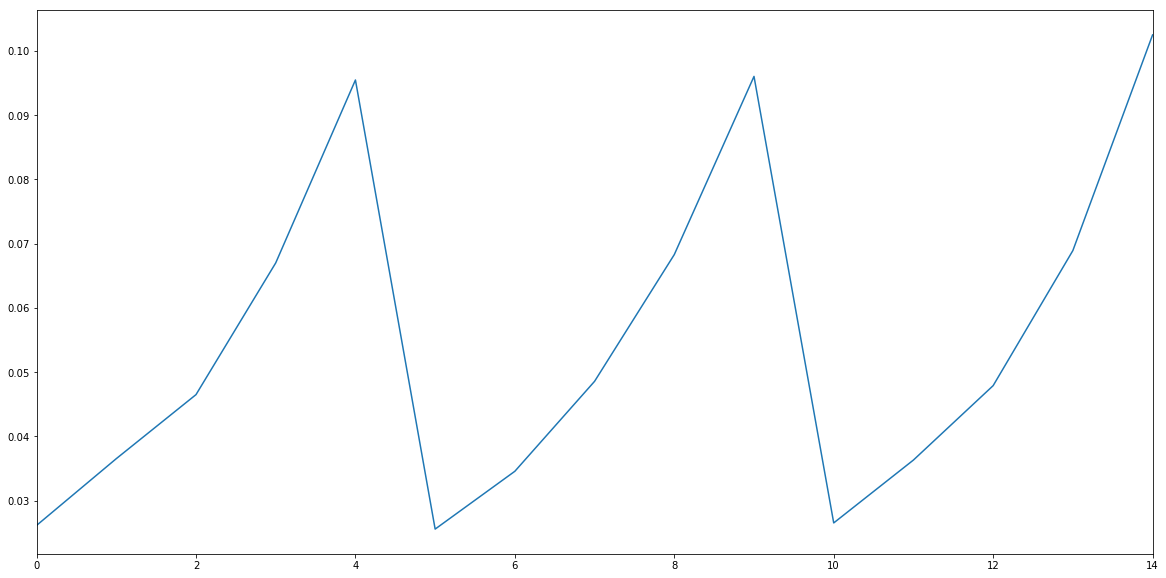

In [7]:
from predictor.dummy_mean_predictor import DummyPredictor
PREDICTOR_NAME = 'dummy'

# Global variables
eval_predictor = DummyPredictor()
step_eval_days = 60  # The step to move between training/validation pairs
params = {'eval_predictor': eval_predictor, 'step_eval_days': step_eval_days}

results_df = misc.parallelize_dataframe(params_list_df, misc.apply_mean_score_eval, params)

results_df['r2'] = results_df.apply(lambda x: x['scores'][0], axis=1)
results_df['mre'] = results_df.apply(lambda x: x['scores'][1], axis=1)
# Pickle that!
results_df.to_pickle('../../data/results_ahead{}_{}_df.pkl'.format(AHEAD_DAYS, PREDICTOR_NAME))
results_df['mre'].plot()

print('Minimum MRE param set: \n {}'.format(results_df.iloc[np.argmin(results_df['mre'])]))
print('Maximum R^2 param set: \n {}'.format(results_df.iloc[np.argmax(results_df['r2'])]))

### - Linear Predictor

Generating: base112_ahead1_train252
Generating: base7_ahead1_train252
Generating: base56_ahead1_train504
Generating: base28_ahead1_train756
Evaluating approximately 87 training/evaluation pairs
Evaluating approximately 79 training/evaluation pairs
Evaluating approximately 82 training/evaluation pairs
Evaluating approximately 86 training/evaluation pairs
Approximately 93.9 percent complete.     (0.83474118806239872, 0.015311829122453153)
Generating: base14_ahead1_train252
Approximately 95.1 percent complete.    Evaluating approximately 87 training/evaluation pairs
Approximately 2.3 percent complete.      (0.98514396205172006, 0.017084716516728497)
Generating: base7_ahead1_train504
Evaluating approximately 83 training/evaluation pairs
Approximately 6.9 percent complete.      (0.97317514043023101, 0.016011555166690748)
Generating: base112_ahead1_train504
Approximately 8.0 percent complete.    Evaluating approximately 81 training/evaluation pairs
Approximately 3.7 percent complete.      (0

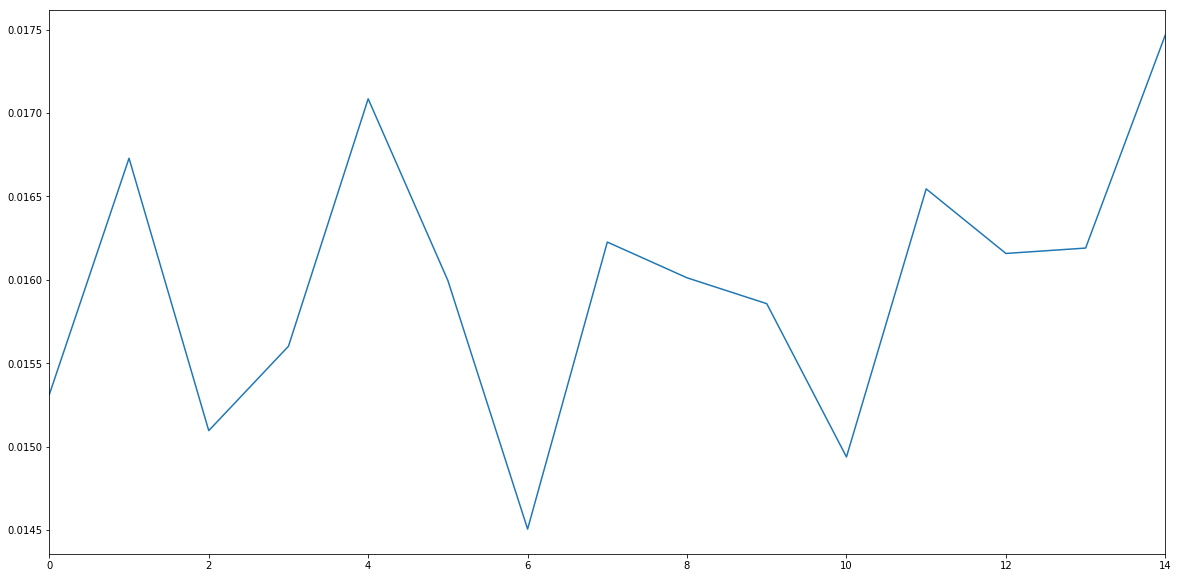

In [8]:
from predictor.linear_predictor import LinearPredictor
PREDICTOR_NAME = 'linear'

# Global variables
eval_predictor = LinearPredictor()
step_eval_days = 60  # The step to move between training/validation pairs
params = {'eval_predictor': eval_predictor, 'step_eval_days': step_eval_days}

results_df = misc.parallelize_dataframe(params_list_df, misc.apply_mean_score_eval, params)

results_df['r2'] = results_df.apply(lambda x: x['scores'][0], axis=1)
results_df['mre'] = results_df.apply(lambda x: x['scores'][1], axis=1)
# Pickle that!
results_df.to_pickle('../../data/results_ahead{}_{}_df.pkl'.format(AHEAD_DAYS, PREDICTOR_NAME))
results_df['mre'].plot()

print('Minimum MRE param set: \n {}'.format(results_df.iloc[np.argmin(results_df['mre'])]))
print('Maximum R^2 param set: \n {}'.format(results_df.iloc[np.argmax(results_df['r2'])]))

### - Random Forest model

Generating: base7_ahead1_train252
Generating: base56_ahead1_train504
Generating: base28_ahead1_train756
Generating: base112_ahead1_train252
Evaluating approximately 87 training/evaluation pairs
Evaluating approximately 79 training/evaluation pairs
Evaluating approximately 82 training/evaluation pairs
Evaluating approximately 86 training/evaluation pairs
Approximately 101.1 percent complete.    (0.79928303123175348, 0.016944762339102845)
Generating: base14_ahead1_train252
Evaluating approximately 87 training/evaluation pairs
Approximately 26.8 percent complete.     (0.88169216009730589, 0.017973703218667317)
Generating: base28_ahead1_train252
Evaluating approximately 87 training/evaluation pairs
Approximately 101.1 percent complete.    (0.93369424339231333, 0.016437060880028449)
Generating: base56_ahead1_train252
Approximately 62.0 percent complete.    Evaluating approximately 86 training/evaluation pairs
Approximately 100.0 percent complete.    (0.98430617407929788, 0.01743933766690715

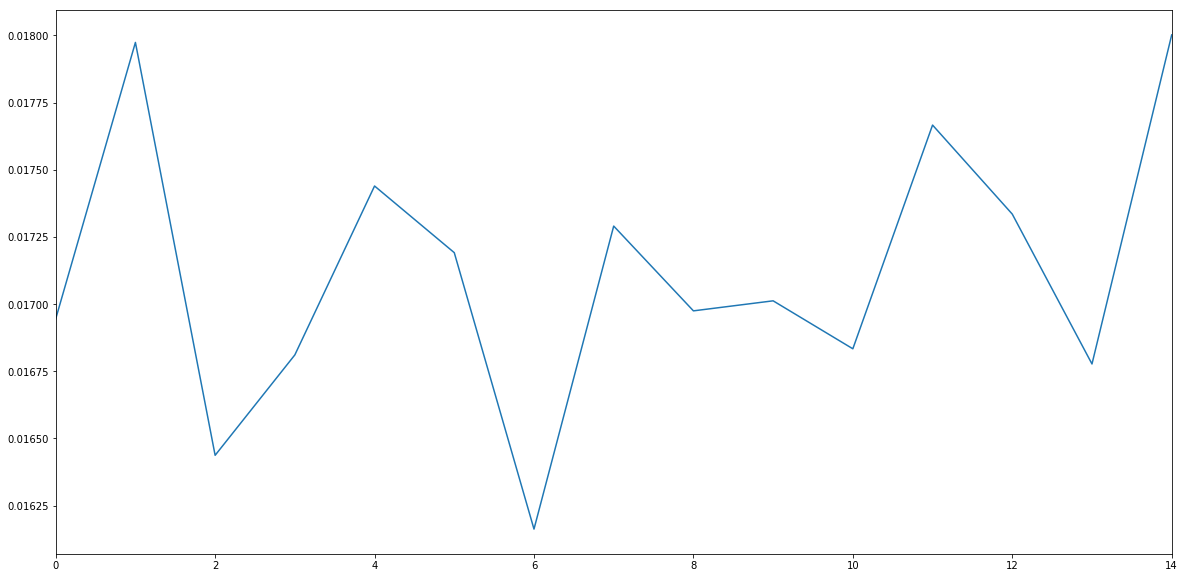

In [9]:
from predictor.random_forest_predictor import RandomForestPredictor
PREDICTOR_NAME = 'random_forest'

# Global variables
eval_predictor = RandomForestPredictor()
step_eval_days = 60  # The step to move between training/validation pairs
params = {'eval_predictor': eval_predictor, 'step_eval_days': step_eval_days}

results_df = misc.parallelize_dataframe(params_list_df, misc.apply_mean_score_eval, params)

results_df['r2'] = results_df.apply(lambda x: x['scores'][0], axis=1)
results_df['mre'] = results_df.apply(lambda x: x['scores'][1], axis=1)
# Pickle that!
results_df.to_pickle('../../data/results_ahead{}_{}_df.pkl'.format(AHEAD_DAYS, PREDICTOR_NAME))
results_df['mre'].plot()

print('Minimum MRE param set: \n {}'.format(results_df.iloc[np.argmin(results_df['mre'])]))
print('Maximum R^2 param set: \n {}'.format(results_df.iloc[np.argmax(results_df['r2'])]))